In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from enum import Enum
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Input, Embedding, Dropout , concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

pd.set_option('display.width', None)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

/Users/rohitanilkumar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rohitanilkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rohitanilkumar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rohitanilkumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
class MultiChannelNeuralNetwork():    
    def lemmatizer(self, sentence):
        wnl = WordNetLemmatizer()
        for word, tag in pos_tag(word_tokenize(sentence)):
            if tag.startswith("NN"):
                yield wnl.lemmatize(word, pos='n')
            elif tag.startswith('VB'):
                yield wnl.lemmatize(word, pos='v')
            elif tag.startswith('JJ'):
                yield wnl.lemmatize(word, pos='a')
            elif tag.startswith('R'):
                yield wnl.lemmatize(word, pos='r')
            else:
                yield word

    def msg_processing(self, raw_msg):
        raw_msg = str(raw_msg)
        raw_msg = str(raw_msg.lower())
        raw_msg = re.sub(r'[^a-zA-Z]', ' ', raw_msg)
        words = raw_msg.lower().split()
        temp_words = []
        
        for i in words:
            if len(i) >= 0:
                temp_words.append(i)
        
        meaningful_words = " ".join([w for w in temp_words])
        return(" ".join(self.lemmatizer(meaningful_words)))

    def helperFunction(self, df, dataset_type):
        print ("Start data preprocessing for {d}".format(d = dataset_type))
        df = df.copy()
        df['comment_text'].fillna('Missing',inplace = True)
        cols = ['comment_text']
        df = df[cols]
        df.loc[:, 'comment_text'] = df['comment_text'].replace({r'[^\x00-\x7F]+':''}, regex=True)
        num_msg = df[cols].size
        clean_msg = []
        for i in range(0,num_msg):
            clean_msg.append(self.msg_processing(df['comment_text'][i]))
        
        df['Processed_msg'] = clean_msg
        new_df = df['Processed_msg']
        print ("Data preprocessing Ends!!!")
        return new_df

    def embedding(self, train,test):
        tokenizer = Tokenizer(num_words=10000)
        tokenizer.fit_on_texts(train)
        trainsequences = tokenizer.texts_to_sequences(train)
        traindata = pad_sequences(trainsequences, maxlen = 100)
        testsequences = tokenizer.texts_to_sequences(test)
        testdata = pad_sequences(testsequences, maxlen=100)
        return traindata, testdata, tokenizer

    def get_coefs(self, word,*arr):
        return word, np.asarray(arr, dtype='float32')


    def embedding_matrix_generator(self, tokenizer, embedding_path):
        embeddings_index = dict(self.get_coefs(*o.strip().split()) for o in open(embedding_path, encoding="utf8"))
        
        word_index = tokenizer.word_index
        nb_words = min(10000, len(word_index))
        embedding_matrix = np.zeros((nb_words, 50))
        
        for word, i in word_index.items():
            if i >= 10000: continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: embedding_matrix[i] = embedding_vector

        return embedding_matrix

    def get_target(self, y):
        ytrain=y[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
        return ytrain


    def multi_channel_model(self, embedding_matrix):
        input1 = Input(shape = (100,))
        embedding1 = Embedding(10000, 50, weights=[embedding_matrix])(input1)
        conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding1)
        drop1 = Dropout(0.4)(conv1)
        pool1 = MaxPooling1D(pool_size=4)(drop1)
        gru1 = GRU(100, dropout=0.2, recurrent_dropout=0.2)(pool1)
        
        
        input2 = Input(shape = (100,))
        embedding2 = Embedding(10000, 50, weights=[embedding_matrix])(input2)
        conv2 = Conv1D(filters = 32, kernel_size = 4, activation = 'relu')(embedding2)
        drop2 = Dropout(0.45)(conv2)
        pool2 = MaxPooling1D(pool_size=4)(drop2)
        gru2 = GRU(100, dropout=0.2, recurrent_dropout=0.2)(pool2)
        
        
        input3 = Input(shape = (100,))
        embedding3 = Embedding(10000, 50, weights=[embedding_matrix])(input3)
        conv3 = Conv1D(filters=32, kernel_size=5, activation='relu')(embedding3)
        drop3 = Dropout(0.5)(conv3)
        pool3 = MaxPooling1D(pool_size=4)(drop3)
        gru3 = GRU(100, dropout=0.2, recurrent_dropout=0.2)(pool3)
        
        
        merged = concatenate([gru1,gru2,gru3])
        dense1 = Dense(100, activation='relu')(merged)
        outputs = Dense(6, activation='sigmoid')(dense1)
        
        model = Model(inputs =[input1, input2, input3], outputs = outputs)
        model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def predict(self, model, df):
        pred = model.predict([df,df,df])
        return pred

    def plot_metrics(self, history):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()


In [3]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [4]:
class CONSTANTS(Enum):
    GLOVE = "/Users/rohitanilkumar/Downloads/glove.6B.50d.txt"
    INPUT = "/Users/rohitanilkumar/Downloads/jigsaw-toxic-comment-classification-challenge/"
    MODEL_DIAGRAM = "/Users/rohitanilkumar/Downloads/jigsaw-toxic-comment-classification-challenge/multichannel.png"

    ENCODING = "ISO-8859-1"
    BATCH = 100
    EPOCH = 10
    
    DELTA = 0.01
    PATIENCE = 3
    MONITOR = "val_loss"

    TRAIN_SIZE = 0.95
    INTERVAL = 1
    RANDOM_SEED = 43

    LABEL_MAPPING = {
        0: "toxic",
        1: "severe_toxic",
        2: "obscene",
        3: "threat",
        4: "insult",
        5: "identity_hate"
    }
    CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    LABEL = "majority_label"

Start data preprocessing for Train dataset
Data preprocessing Ends!!!
Start data preprocessing for Test dataset
Data preprocessing Ends!!!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 50)          

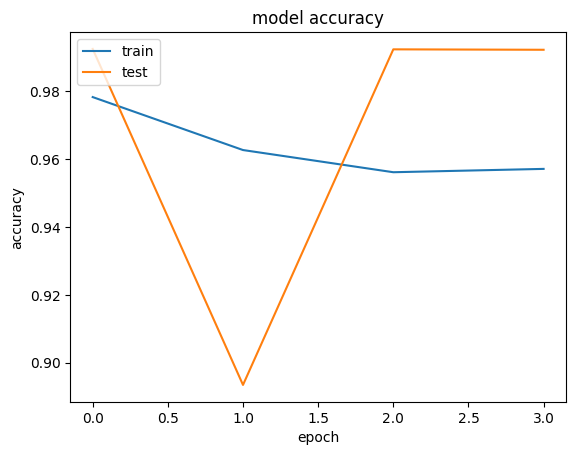

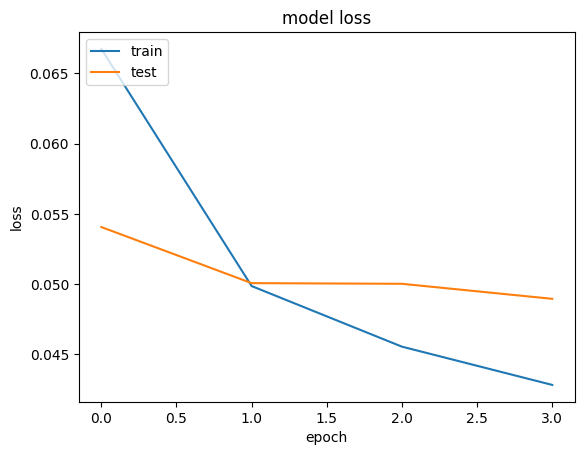

4787/4787 [==============================] - 23s 5ms/step


In [5]:
if __name__ == "__main__":

    train_df= pd.read_csv(CONSTANTS.INPUT.value + "train.csv", encoding = CONSTANTS.ENCODING.value) 
    test_df = pd.read_csv(CONSTANTS.INPUT.value + "test.csv", encoding = CONSTANTS.ENCODING.value) 

    nn_obj = MultiChannelNeuralNetwork()
    processed_train_df = nn_obj.helperFunction(train_df, "Train dataset")
    processed_test_df = nn_obj.helperFunction(test_df, "Test dataset")

    xtrain,xtest,tokenizer = nn_obj.embedding(processed_train_df, processed_test_df)
    embedding_matrix = nn_obj.embedding_matrix_generator(tokenizer, CONSTANTS.GLOVE.value)
    ytrain = nn_obj.get_target(train_df[CONSTANTS.CLASSES.value])

    X_train, X_val, y_train, y_val = train_test_split(xtrain, ytrain, train_size = CONSTANTS.TRAIN_SIZE.value, 
                                                      random_state = CONSTANTS.RANDOM_SEED.value)
    
    model = nn_obj.multi_channel_model(embedding_matrix)
    print(model.summary())
    plot_model(model, show_shapes = True, to_file = CONSTANTS.MODEL_DIAGRAM.value)
    
    RocAuc = RocAucEvaluation(validation_data = ([X_val,X_val, X_val], y_val), interval = 1)
    es = EarlyStopping(patience = CONSTANTS.PATIENCE.value, min_delta = CONSTANTS.DELTA.value, 
                       monitor = CONSTANTS.MONITOR.value, restore_best_weights = True)

    hist = model.fit([X_train, X_train, X_train], y_train, batch_size = CONSTANTS.BATCH.value, epochs=CONSTANTS.EPOCH.value, 
                     validation_data=([X_val, X_val, X_val], y_val), callbacks=[RocAuc, es])
    nn_obj.plot_metrics(hist)
    prediction = nn_obj.predict(model, xtest)

    predicted_class = [np.argmax(pred) for pred in prediction]
    predicted_labels = [CONSTANTS.LABEL_MAPPING.value[idx] for idx in predicted_class]
    test_df[CONSTANTS.CLASSES.value] = prediction
    test_df[CONSTANTS.LABEL.value] = predicted_labels

In [6]:
test_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,majority_label
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.981270,0.156566,0.737204,0.053441,0.757012,0.135018,toxic
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.008509,0.000091,0.001673,0.000219,0.001915,0.000175,toxic
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.058075,0.004832,0.021161,0.009680,0.025415,0.005522,toxic
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.002511,0.000010,0.000320,0.000018,0.000615,0.000017,toxic
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.011497,0.000237,0.002305,0.000442,0.002924,0.000275,toxic
...,...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0.639863,0.005841,0.188451,0.006469,0.265342,0.013599,toxic
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0.039221,0.000159,0.004055,0.000816,0.006487,0.001057,toxic
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0.001349,0.000004,0.000139,0.000010,0.000260,0.000015,toxic
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0.001469,0.000009,0.000235,0.000040,0.000241,0.000100,toxic
